In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('/mloscratch/homes/yixuan/PDM')

In [7]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings
from utils.comon_substring import CommonSubstringMatcher

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

def get_checkpoints(expr_base_dir):
    """
    Get sorted checkpoints from directory
    
    Parameters
    ----------
    expr_base_dir : str
        Base directory containing checkpoints
        
    Returns
    -------
    list
        Sorted list of (step, consumed) tuples
    """
    return sorted([(int(f.name.split('=')[1].split('-')[0]), int(f.name.split('=')[2]))
                  for f in Path(expr_base_dir).glob("step=*")])

def load_inference_data(base_dir, step, consumed):
    """
    Load inference data from a given step and restore original data order.
    DistributedSampler distributes data in round-robin fashion (e.g., GPU0: [0,8,16,...], GPU1: [1,9,17,...]).
    This function loads data from all rank files and reorders it back to sequential order [0,1,2,...].
    
    Parameters
    ----------
    base_dir : str
        Base directory path 
    step : int
        Training step
    consumed : int
        Number of consumed tokens
        
    Returns
    -------
    Dataset
        HuggingFace dataset with data restored to original sequential order
    """
    file_path = Path(base_dir) / f"step={step}-consumed={consumed}"
    rank_files = sorted(file_path.glob("rank*.jsonl"))
    world_size = len(rank_files)

    # Load data from all ranks
    dataset = load_dataset(
        'json', 
        data_files=[str(f) for f in rank_files], 
        split='train'
    )
    
    total_size = len(dataset)
    items_per_rank = total_size // world_size

    # Reorder to original sequential order
    orig_indices = np.arange(total_size).reshape(world_size, items_per_rank).T.flatten()
    
    return dataset.select(orig_indices)

def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            lcs_res = find_longest_common_substrings(data['true_suffix'], data['generated_suffix'])
            steps.append(step)
            avg_lengths.append(lcs_res.max_length.mean())
            
        results[model_id] = {'steps': steps, 'avg_lengths': avg_lengths}
    
    return results

In [9]:
def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate LCS for each split
            lcs_results = {}
            for split_name, split_data in splits.items():
                lcs_res = find_longest_common_substrings(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                lcs_results[split_name] = lcs_res.max_length.mean()
            
            steps.append(step)
            avg_lengths.append(lcs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [10]:
def plot_comparison(results, exclude_models=None, exclude_splits=None):
    """
    Plot comparison of models with train/val/test splits
    
    Parameters
    ----------
    results : dict
        Dictionary containing results for each model and split
    exclude_models : list, optional
        List of model IDs to exclude from plotting
    exclude_splits : list, optional
        List of split names to exclude from plotting
    """
    plt.figure(figsize=(12, 6))
    
    # Line styles for different splits
    styles = {
        'train': '-',
        'val': '--',
        'test': ':'
    }
    
    # Filter out excluded splits
    if exclude_splits:
        styles = {k: v for k, v in styles.items() if k not in exclude_splits}
    
    # Filter out excluded models and plot remaining ones
    for model_name, model_results in results.items():
        if exclude_models and model_name in exclude_models:
            continue
            
        # Plot each split with different line style
        for split_name, style in styles.items():
            split_data = model_results[split_name]

            # Convert steps to epochs
            epochs = [step/75 for step in split_data['steps']]

            plt.plot(epochs, split_data['avg_lengths'],
                    linestyle=style,
                    marker='o', 
                    label=f'{model_name} ({split_name})',
                    alpha=0.7)
    
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Memorisation Length')
    plt.title('Average Longest Verbatim Memorisation Length vs Training Steps')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

In [ ]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
results = calc_avg_lcs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73efc0506620>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


In [1]:
import pickle  # or import json
import os

# Using pickle (better for complex Python objects)
def save_results(results, save_path):
    """
    Save results dictionary to a file
    
    Parameters
    ----------
    results : dict
        Dictionary containing results
    save_path : str
        Path to save the results (e.g., 'results/data.pkl')
    """
    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

In [22]:
save_results(results, './avg_lcs.pkl')

In [ ]:
# with open('./avg_lcs.pkl', 'rb') as f:
#     loaded_results = pickle.load(f)

In [11]:
def calc_avg_cs_lengths(base_dir, model_ids):
    """
    Calculate average common substring lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate CS for each split
            cs_results = {}
            for split_name, split_data in splits.items():
                cs_master = CommonSubstringMatcher(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                matches = cs_master.get_all_matches()
                # Using nanmean for samples with all None matches
                cs_results[split_name] = np.nanmean([
                    np.mean([match.length if match is not None else 0 for match in sample])
                    for sample in matches
                ])
            
            steps.append(step)
            avg_lengths.append(cs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [12]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]

In [ ]:
results = calc_avg_cs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Computed DP matrices in 3.24 seconds.


In [ ]:
results

{'llama_1.5B_Standard_GBS_120_EPOCH_75': {'train': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5625],
   'avg_lengths': [2.0560902220590602,
    2.079706905742516,
    2.094903746079558,
    2.131199570689665,
    2.4753257438632024,
    6.960085749103515,
    15.162011952126415,
    28.2380543766751,
    48.301167194427336,
    68.02317272002385,
    104.04284082822612,
    145.6790414871139,
    239.19811198988717,
    316.67629301502524,
    398.58152510040554,
    452.163529618922,
    470.73478298442416,
    485.0545411422915,
    487.1674695096553]},
  'val': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5625],
   'avg_lengths': [2.056723846260528,
    2.0775099226958,
    2.0795105692478018,
    2.

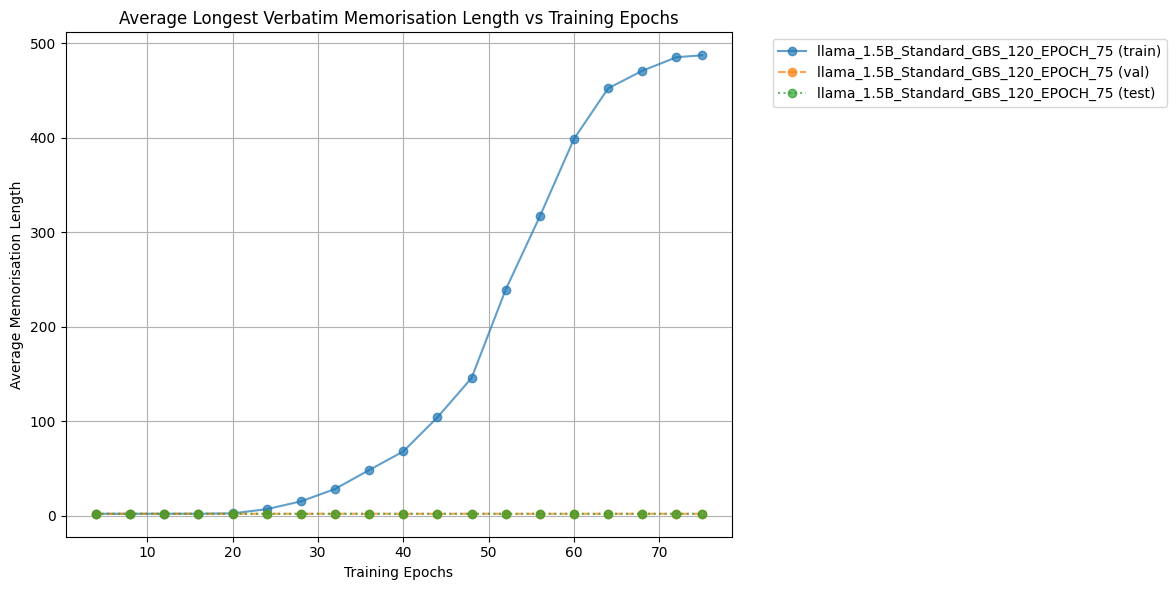

In [ ]:
plot_comparison(results)

In [ ]:
save_results(results, '../results/avg_cs.pkl')

In [ ]:
def plot_comparison(results, include_ckpts=None, include_splits=None, title=None, log_y=False):
   """
   Plot comparison of models with train/val/test splits
   
   Parameters
   ----------
   results : dict
       Dictionary containing results for each model and split
   include_ckpts : list, optional
       List of model IDs to include in plotting. If None, includes all models.
   include_splits : list, optional
       List of split names to include in plotting. If None, includes all splits.
   title : str, optional
       Custom title for the plot. If None, uses default title.
   log_y : bool, optional
       Whether to use log scale for y-axis
       
   Examples
   --------
   >>> # Plot all models and splits
   >>> plot_comparison(results)
   
   >>> # Include only specific models and splits
   >>> plot_comparison(results, 
   ...                include_ckpts=['llama_1.5B_Standard'],
   ...                include_splits=['train', 'val'])
   
   >>> # Custom title and log scale
   >>> plot_comparison(results,
   ...                title='Model Comparison',
   ...                log_y=True)
   """
   plt.figure(figsize=(12, 6))
   
   # Line styles for different splits
   all_styles = {
       'train': '-',
       'val': '--',
       'test': ':'
   }
   
   # Filter splits to include
   styles = all_styles if include_splits is None else {
       k: v for k, v in all_styles.items() if k in include_splits
   }
   
   # Filter models and plot
   models_to_plot = results.keys() if include_ckpts is None else include_ckpts
   
   for model_name in models_to_plot:
       if model_name not in results:
           continue
           
       model_results = results[model_name]
       
       # Plot each included split
       for split_name, style in styles.items():
           split_data = model_results[split_name]
           
           # Convert steps to epochs
           epochs = [step/75 for step in split_data['steps']]
           
           plt.plot(epochs, split_data['avg_lengths'],
                   linestyle=style,
                   marker='o', 
                   label=f'{model_name} ({split_name})',
                   alpha=0.7)
   
   plt.xlabel('Training Epochs')
   plt.ylabel('Average Memorisation Length')
   
   # Use custom title if provided, otherwise use default
   plot_title = title if title else 'Average Longest Verbatim Memorisation Length vs Training Epochs'
   plt.title(plot_title)
   
   # Set y-axis to log scale if requested
   if log_y:
       plt.yscale('log')
   
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True)
   plt.tight_layout()
   
   plt.show()

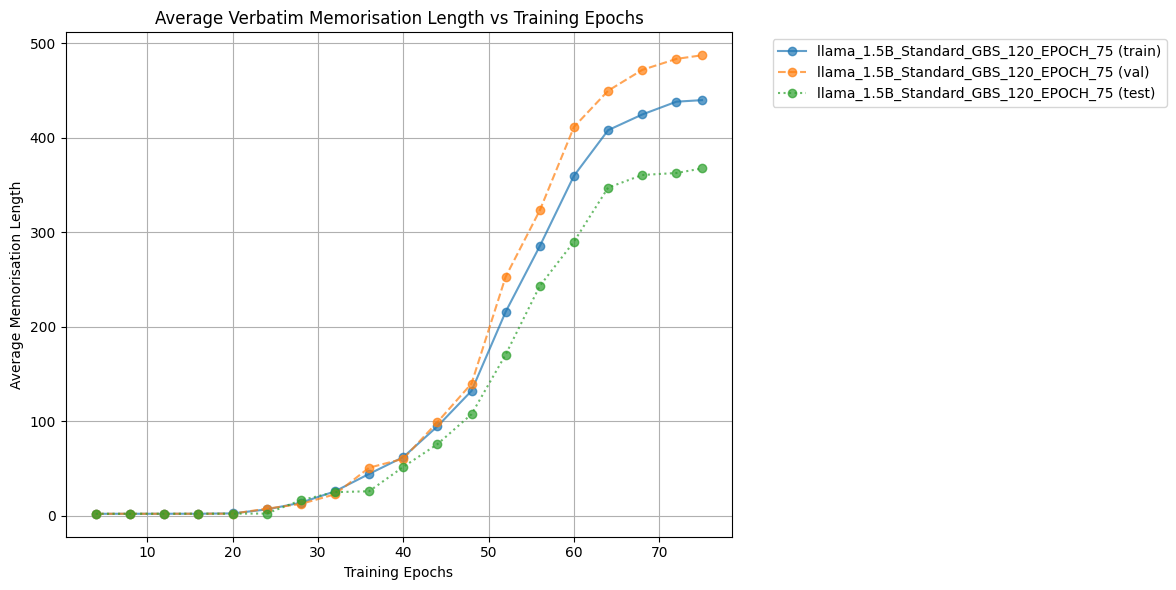

In [ ]:
plot_comparison(
    results=results, 
    include_ckpts=[
        # "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        # "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        # "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        'val', 
        'test'
    ],
    title='Average Verbatim Memorisation Length vs Training Epochs'
)